In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

all_datas = []
links = []
page = 1

# 5페이지까지 링크 가져오기
for page in range(5):
    news_link = requests.get(f'https://www.hankyung.com/economy/macro?page={page}')
    soup = BeautifulSoup(news_link.text, 'html.parser')
    links.extend([l.attrs['href'] for l in soup.select("h2.news-tit a")])

# 제목 및 본문 가져오기
for i,link in enumerate(links):
    news = requests.get(link)
    soup = BeautifulSoup(news.text, 'html.parser')
    title = soup.select_one("h1.headline").text.strip()
    content = soup.select_one("div.article-body").text.strip()
    all_datas.append({"title": title, "content": content})

# DataFrame으로 변환
news_df = pd.DataFrame(all_datas)

# CSV로 저장 (선택 사항)
news_df.to_csv("news_data.csv", index=False, encoding="utf-8-sig")

In [2]:
news_df

,title,content
0,외출할 때 반려견 목줄 착용 하나요? 반려인·비반려인 물었더니,지난해 10월 서울 송파구 탄천유수지 반려견놀이터에서 '송파 반려동물 한마당'이 열...
1,"육지만큼 뜨거웠던 바다…작년 한국 표층수온, 관측 사상 가장 높았다",지난해 8월 늦은 저녁 서울 여의도한강공원에서 시민들이 더위를 식히고 있는 모습. ...
2,"살아나지 않는 소비심리…""현재 경기 너무 나쁘다""",비상계엄 사태로 급락한 소비심리가 이달에도 살아나지 않고 있는 것으로 조사됐다. 소...
3,연말연시 특수 실종 외식 매출 13주째 ↓ 벼랑에 선 자영업자,"지난달 비상계엄 및 탄핵 사태, 올해 초 전남 무안 제주항공 참사 여파로 연말연시 ..."
4,"""올 성장률 1.6~1.7% … 정치 불확실성이 0.2%P 낮춰""",한국은행이 올해 한국 경제성장률이 1.6%에 그칠 수 있다고 경고했다. 정치적 불확...
...,...,...
95,고용 이어 생산·소비·투자 '4重 쇼크'…4분기 0.5% 성장도 위태,지난달 취업자 증가폭이 내수 부진 여파로 넉 달 만에 10만 명을 밑돈 데 이어 산...
96,꺼져가는 경기부터 살리자…15년 만에 2연속 금리 내린 이창용,이창용 한국은행 총재(가운데)가 28일 금융통화위원회 통화정책방향 회의에서 의사봉을...
97,1.9%·1.8%…저성장 고착 예고한 한은,이미지 크게보기\n\n\n< 2회 연속 기준금리 인하 > 한국은행이 28일 기준금리...
98,20년 만에 나왔다…부총재 소수의견,유상대 한국은행 부총재(사진)가 28일 한은 금융통화위원회 통화정책방향 회의에서 기...


In [3]:
!pip install konlpy
!pip install pyLDAvis
!pip install wordcloud
# !pip install --upgrade pyLDAvis

In [4]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import gensim
from gensim import corpora
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict

In [5]:
# 형태소 분석기 Okt 로드
okt = Okt()

# 불용어 리스트 (한국어에 맞게 수정)
stop_words = set(['을', '를', '이', '가', '에', '와', '과', '도', '으로', '하다', '있다', '이다'])

# 문서별로 형태소 분석, 명사만 추출하고 불용어 제거
news_df['clean_doc'] = news_df['content'].apply(lambda x: ' '.join([word for word in okt.nouns(x) if word not in stop_words and len(word) > 1]))

# 토큰화
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Gensim의 사전 객체 생성
dictionary = corpora.Dictionary(tokenized_doc)

# 각 문서를 BOW로 벡터화 (id, 빈도)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]

# TF-IDF 모델 생성 및 적용
tfidf_model = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# LDA 모델 적용 (TF-IDF 기반)
NUM_TOPICS = 10
ldamodel_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
topics_tfidf = ldamodel_tfidf.print_topics(num_words=4)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
topics_tfidf

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.006*"업자" + 0.006*"자영" + 0.004*"지원" + 0.003*"원금"'),
 (1, '0.002*"국가신용등급" + 0.002*"서한" + 0.002*"귀어" + 0.002*"면허"'),
 (2, '0.004*"주주" + 0.003*"자산운용" + 0.003*"머스트" + 0.003*"밸류업"'),
 (3, '0.005*"대출" + 0.004*"반려" + 0.002*"세수" + 0.002*"반려동물"'),
 (4, '0.004*"수온" + 0.003*"연체" + 0.003*"대출" + 0.003*"음식점"'),
 (5, '0.005*"등급" + 0.003*"소통" + 0.002*"타이밍" + 0.002*"주크"'),
 (6, '0.010*"금리" + 0.008*"인하" + 0.006*"환율" + 0.006*"성장"'),
 (7, '0.002*"브리핑" + 0.002*"양국" + 0.002*"선택" + 0.002*"가결"'),
 (8, '0.002*"합계출산율" + 0.002*"선진국" + 0.002*"출생" + 0.002*"관광객"'),
 (9, '0.002*"탄소" + 0.002*"총수요" + 0.002*"매입" + 0.002*"금융채"')]

In [9]:
# LDA 시각화
pyLDAvis.enable_notebook()
vis_tfidf = pyLDAvis.gensim_models.prepare(ldamodel_tfidf, corpus_tfidf, dictionary)
pyLDAvis.display(vis_tfidf)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# 특정 토픽의 상위 10개 단어와 가중치 가져오기 (예: 0번 토픽)
topic_0 = ldamodel_tfidf.show_topic(0, topn=20)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
topic_0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('업자', 0.00574225),
 ('자영', 0.0057422323),
 ('지원', 0.004075505),
 ('원금', 0.0031452351),
 ('신용', 0.0031360742),
 ('흑자', 0.0028932225),
 ('타깃', 0.0028372589),
 ('실기', 0.002632371),
 ('대출', 0.0026307378),
 ('원화', 0.0025597073),
 ('중대', 0.0025480457),
 ('경상수지', 0.0022764797),
 ('취약', 0.0022753947),
 ('규모', 0.0021365182),
 ('차주', 0.0021259577),
 ('소득', 0.002117884),
 ('국민', 0.0021034584),
 ('보고서', 0.0020741897),
 ('해외', 0.002048712),
 ('최적', 0.001987382)]

In [12]:
# 로컬
# from matplotlib import font_manager

# # "Malgun Gothic" 또는 원하는 폰트 검색
# font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# for font in font_list:
#     if "malgun" in font.lower():  # "malgun"을 원하는 폰트 이름으로 변경
#         print(font)
#     if "AppleGothic" in font.lower():
#         print(font)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
!apt-get update -qq
!apt-get install fonts-nanum -qq

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


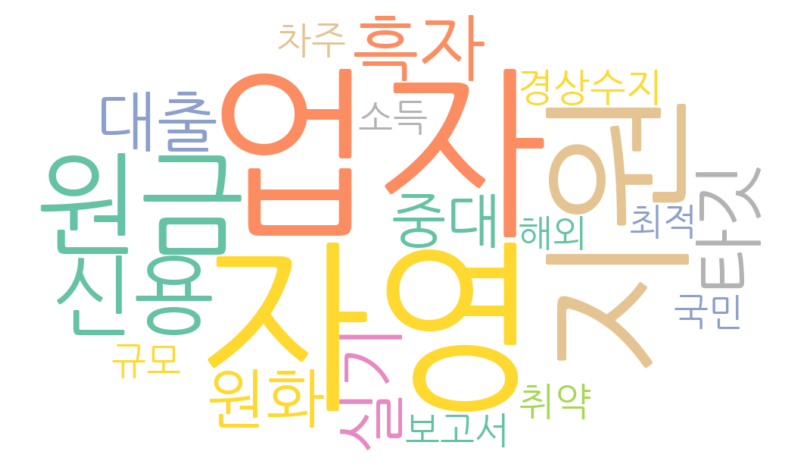

In [14]:
# 한글 폰트 파일 경로 설정 (예: 나눔고딕 폰트)
# font_path = "C:/Windows/Fonts/malgun.ttf"
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# 이미지 불러오기 (배경은 흰색, 글자 모양은 검정색으로 설정)
mask_image = np.array(Image.open('wordcloud_image.png'))

# 워드 클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,
    width=3000,
    height=2000,
    random_state=123,
    background_color="white",  # 배경을 흰색으로 설정
    colormap="Set2",
    collocations=False,
    stopwords=STOPWORDS,
    mask=mask_image
).generate_from_frequencies(dict(topic_0))

# 워드 클라우드 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


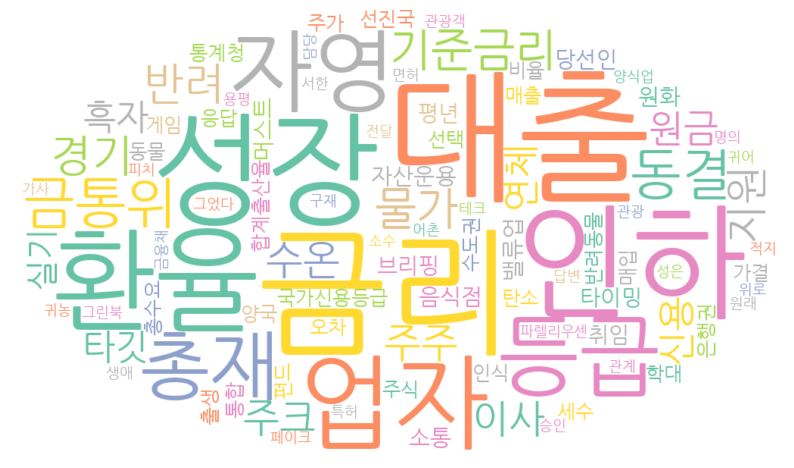

In [15]:
# 전체 토픽의 상위 단어들을 합산
word_weights = defaultdict(float)

# LDA 모델에서 각 토픽의 상위 10개 단어와 가중치를 가져와서 합산
for topic_id in range(NUM_TOPICS):
    topic = ldamodel_tfidf.show_topic(topic_id, topn=10)  # 각 토픽의 상위 10개 단어 가져오기
    for word, weight in topic:
        word_weights[word] += weight  # 단어의 가중치를 누적

# 이미지 불러오기 (배경은 흰색, 글자 모양은 검정색으로 설정)
mask_image = np.array(Image.open('wordcloud_image.png'))

# 전체 토픽 기반 워드 클라우드 생성
wordcloud = WordCloud(
    font_path=font_path,  # 한글 폰트 경로 설정
    width=3000,
    height=2000,
    random_state=123,
    background_color="white",  # 배경을 흰색으로 설정
    colormap="Set2",
    collocations=False,
    stopwords=STOPWORDS,
    mask=mask_image
).generate_from_frequencies(word_weights)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


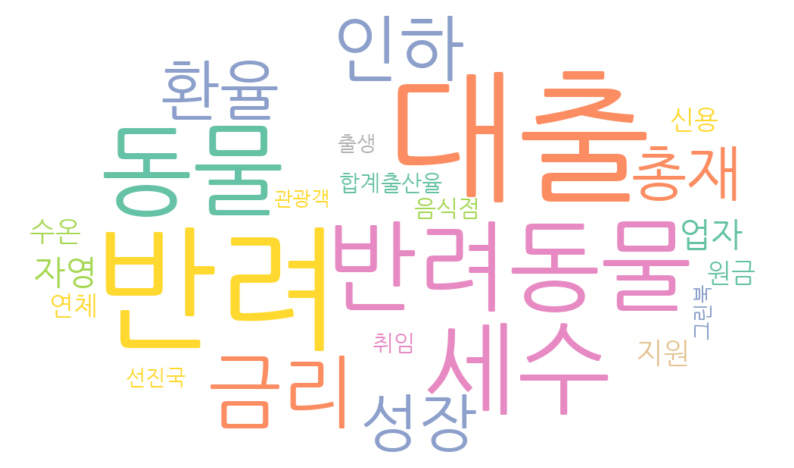

In [16]:
# 이미지 불러오기 (배경은 흰색, 글자 모양은 검정색으로 설정)
mask_image = np.array(Image.open('wordcloud_image.png'))

def create_wordcloud_for_document(document_id, num_topics=3, num_words=5):
    # 문서별 토픽 비율 확인
    topic_distribution = ldamodel_tfidf[corpus_tfidf[document_id]]

    # 상위 3개의 토픽을 추출 (비율 기준으로 정렬)
    top_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[:num_topics]

    # 상위 토픽에서 단어와 가중치 추출
    word_weights = defaultdict(float)
    for topic_id, topic_weight in top_topics:
        topic_words = ldamodel_tfidf.show_topic(topic_id, topn=num_words)
        for word, weight in topic_words:
            word_weights[word] += weight * topic_weight  # 단어 가중치에 토픽 비율을 반영하여 합산

    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,  # 한글 폰트 경로 설정
        width=3000,
        height=2000,
        random_state=123,
        background_color="white",  # 배경을 흰색으로 설정
        colormap="Set2",
        collocations=False,
        mask=mask_image
    ).generate_from_frequencies(word_weights)

    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# 문서 ID를 이용하여 워드 클라우드 생성 (예: 0번 문서)
create_wordcloud_for_document(document_id=0, num_topics=5, num_words=5)


In [17]:
ldamodel_tfidf[corpus_tfidf[0]]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.01393101),
 (1, 0.013929922),
 (2, 0.013929942),
 (3, 0.7879906),
 (4, 0.013930663),
 (5, 0.013929936),
 (6, 0.10056813),
 (7, 0.013929928),
 (8, 0.013929948),
 (9, 0.01392994)]

In [18]:
len(list(corpus_tfidf))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100

In [19]:
corpus_tfidf[0]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.08112031647142799),
 (1, 0.03139718776670398),
 (2, 0.03047542911588434),
 (3, 0.08112031647142799),
 (4, 0.05237390134540194),
 (5, 0.049931534029526284),
 (6, 0.022989400327259636),
 (7, 0.08112031647142799),
 (8, 0.043966113905957595),
 (9, 0.07271252903198366),
 (10, 0.08793222781191519),
 (11, 0.0015048371548797544),
 (12, 0.08112031647142799),
 (13, 0.06674710890841495),
 (14, 0.04237023780700043),
 (15, 0.04725497243875173),
 (16, 0.041233939040838614),
 (17, 0.243360949414284),
 (18, 0.08112031647142799),
 (19, 0.08112031647142799),
 (20, 0.08112031647142799),
 (21, 0.04230633589118167),
 (22, 0.16224063294285598),
 (23, 0.08112031647142799),
 (24, 0.08112031647142799),
 (25, 0.567842215299996),
 (26, 0.16224063294285598),
 (27, 0.243360949414284),
 (28, 0.017023980203690944),
 (29, 0.07271252903198366),
 (30, 0.08112031647142799),
 (31, 0.07271252903198366),
 (32, 0.05833932146897062),
 (33, 0.16542848710998243),
 (34, 0.05514282903666081),
 (35, 0.05833932146897062),
 

In [20]:
news_df

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,content,clean_doc
0,외출할 때 반려견 목줄 착용 하나요? 반려인·비반려인 물었더니,지난해 10월 서울 송파구 탄천유수지 반려견놀이터에서 '송파 반려동물 한마당'이 열...,지난해 서울 송파구 탄천 유수지 반려견 놀이터 송파 반려동물 마당 모습 연합뉴스 반...
1,"육지만큼 뜨거웠던 바다…작년 한국 표층수온, 관측 사상 가장 높았다",지난해 8월 늦은 저녁 서울 여의도한강공원에서 시민들이 더위를 식히고 있는 모습. ...,지난해 저녁 서울 여의도 한강 공원 시민 더위 모습 김범준 기자 지난해 한국 주변 ...
2,"살아나지 않는 소비심리…""현재 경기 너무 나쁘다""",비상계엄 사태로 급락한 소비심리가 이달에도 살아나지 않고 있는 것으로 조사됐다. 소...,비상계엄 사태 급락 소비 심리 조사 소비 심리 지수 반등 장기 평균 크게 한국은행 ...
3,연말연시 특수 실종 외식 매출 13주째 ↓ 벼랑에 선 자영업자,"지난달 비상계엄 및 탄핵 사태, 올해 초 전남 무안 제주항공 참사 여파로 연말연시 ...",지난달 비상계엄 탄핵 사태 올해 전남 무안 제주항공 참사 여파 연말 영업 매출 크게...
4,"""올 성장률 1.6~1.7% … 정치 불확실성이 0.2%P 낮춰""",한국은행이 올해 한국 경제성장률이 1.6%에 그칠 수 있다고 경고했다. 정치적 불확...,한국은행 올해 한국 경제성장률 경고 정치 불확실 소비 위축 당초 전망 성장 정치 일...
...,...,...,...
95,고용 이어 생산·소비·투자 '4重 쇼크'…4분기 0.5% 성장도 위태,지난달 취업자 증가폭이 내수 부진 여파로 넉 달 만에 10만 명을 밑돈 데 이어 산...,지난달 취업 증가 부진 여파 밑돈 산업 생산 소비 투자 전월 대비 산업 활동 구성 ...
96,꺼져가는 경기부터 살리자…15년 만에 2연속 금리 내린 이창용,이창용 한국은행 총재(가운데)가 28일 금융통화위원회 통화정책방향 회의에서 의사봉을...,이창용 한국은행 총재 가운데 금융통화위원회 통화정책 방향 회의 의사 금융시장 예상 ...
97,1.9%·1.8%…저성장 고착 예고한 한은,이미지 크게보기\n\n\n< 2회 연속 기준금리 인하 > 한국은행이 28일 기준금리...,이미지 크게 보기 연속 기준금리 인하 한국은행 기준금리 포인트 전격 인하 지난달 연...
98,20년 만에 나왔다…부총재 소수의견,유상대 한국은행 부총재(사진)가 28일 한은 금융통화위원회 통화정책방향 회의에서 기...,유상 한국은행 총재 사진 금융통화위원회 통화정책 방향 회의 기준금리 인하 결정 반대...


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
